In [1]:
import pandas as pd
from google.colab import files
import json

# Step 1: Upload your JSON file
uploaded = files.upload()

# Step 2: Load the JSON file
# Replace 'your_file.json' with the name of the uploaded file
filename = next(iter(uploaded))  # Gets the uploaded filename
try:
    df = pd.read_json(filename, lines=True)  # Use lines=True for JSON Lines format
except ValueError:
    with open(filename, 'r') as f:
        data = json.load(f)
    df = pd.json_normalize(data)

# Step 3: Convert to CSV
csv_filename = filename.replace('.json', '.csv')
df.to_csv(csv_filename, index=False)

# Step 4: Download the CSV file
files.download(csv_filename)


Saving sensor_data1.json to sensor_data1.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import json

# Step 1: Load JSON file (adjust lines=True if JSON lines)
filename = 'sensor_data1.json'

try:
    df = pd.read_json(filename, lines=True)  # try JSON lines format
except ValueError:
    with open(filename, 'r') as f:
        data = json.load(f)
    df = pd.json_normalize(data)

print("Initial data shape:", df.shape)
print(df.head())

# Step 2: Check for nested columns and flatten if any
# (If you see columns with dict or list type, flatten them)
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
        print(f"Flattening nested column: {col}")
        nested_df = pd.json_normalize(df[col])
        nested_df.columns = [f"{col}_{subcol}" for subcol in nested_df.columns]
        df = df.drop(columns=[col]).join(nested_df)

print("After flattening nested columns:")
print(df.head())

# Step 3: Handle missing values
print("Missing values per column:")
print(df.isnull().sum())

# You can choose to fill or drop missing data; here is an example fill
df = df.fillna(method='ffill').fillna(method='bfill')

# Step 4: Convert timestamps (if any column stores timestamps)
# Common column names for time: 'timestamp', 'time', 'date'
time_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print("Datetime conversion done for:", time_cols)

# Step 5: (Optional) Normalize numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns:", numeric_cols)

# Example: Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("After scaling numeric features:")
print(df.head())

# Step 6: Save the preprocessed dataframe as CSV (optional)
df.to_csv('sensor_data1_preprocessed.csv', index=False)

print("Preprocessing complete. Saved to sensor_data1_preprocessed.csv")


Initial data shape: (33, 10)
             timestamp      accX      accY      accZ     gyroX     gyroY  \
0  2025-06-07 12:20:54 -0.118104  0.005988  9.806258 -0.000989 -0.000574   
1  2025-06-07 12:20:54 -0.118553  0.005389  9.815838  0.004334  0.000626   
2  2025-06-07 12:20:55 -0.118553  0.005389  9.815838  0.004334  0.000626   
3  2025-06-07 12:20:55 -0.118553  0.005389  9.815838  0.004334  0.000626   
4  2025-06-07 12:20:56 -0.118553  0.005389  9.815838  0.004334  0.000626   

      gyroZ     gpsLat     gpsLon        gpsZ  
0 -0.002055  43.801635 -79.332435  188.518658  
1 -0.001840  43.801633 -79.332493  199.845245  
2 -0.001840  43.801633 -79.332493  199.845245  
3 -0.001840  43.801633 -79.332493  199.845245  
4 -0.001840  43.801633 -79.332493  199.845245  
After flattening nested columns:
             timestamp      accX      accY      accZ     gyroX     gyroY  \
0  2025-06-07 12:20:54 -0.118104  0.005988  9.806258 -0.000989 -0.000574   
1  2025-06-07 12:20:54 -0.118553  0.00538

<ipython-input-2-5018b54f47ee>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


After scaling numeric features:
            timestamp      accX      accY      accZ     gyroX     gyroY  \
0 2025-06-07 12:20:54  0.528302  0.457627  0.510490  0.301368  0.404954   
1 2025-06-07 12:20:54  0.500000  0.423729  0.958042  1.000000  0.647949   
2 2025-06-07 12:20:55  0.500000  0.423729  0.958042  1.000000  0.647949   
3 2025-06-07 12:20:55  0.500000  0.423729  0.958042  1.000000  0.647949   
4 2025-06-07 12:20:56  0.500000  0.423729  0.958042  1.000000  0.647949   

      gyroZ    gpsLat    gpsLon      gpsZ  
0  0.024495  0.718095  1.000000  0.009834  
1  0.068918  0.608829  0.450153  1.000000  
2  0.068918  0.608829  0.450153  1.000000  
3  0.068918  0.608829  0.450153  1.000000  
4  0.068918  0.608829  0.450153  1.000000  
Preprocessing complete. Saved to sensor_data1_preprocessed.csv


In [3]:
import pandas as pd
import numpy as np

# Load preprocessed data
df = pd.read_csv('sensor_data1_preprocessed.csv', parse_dates=['timestamp'])

# Sort by timestamp (important for time-series features)
df = df.sort_values('timestamp').reset_index(drop=True)

# 1. Calculate Magnitudes (vector norms) for accelerometer and gyroscope
df['acc_magnitude'] = np.sqrt(df['accX']**2 + df['accY']**2 + df['accZ']**2)
df['gyro_magnitude'] = np.sqrt(df['gyroX']**2 + df['gyroY']**2 + df['gyroZ']**2)

# 2. Create Rolling/Window Statistics (window size: 3 samples, adjust as needed)
window_size = 3

rolling_features = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'acc_magnitude', 'gyro_magnitude']

for feature in rolling_features:
    df[f'{feature}_roll_mean'] = df[feature].rolling(window=window_size).mean()
    df[f'{feature}_roll_std'] = df[feature].rolling(window=window_size).std()
    df[f'{feature}_roll_min'] = df[feature].rolling(window=window_size).min()
    df[f'{feature}_roll_max'] = df[feature].rolling(window=window_size).max()

# 3. Create Lag/Shift Features (lags 1 and 2 steps)
lags = [1, 2]

for lag in lags:
    for feature in rolling_features:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

# Optional: Drop rows with NaNs created by rolling/lag
df = df.dropna().reset_index(drop=True)

# Save enhanced features dataset
df.to_csv('sensor_data1_featured.csv', index=False)

print(df.head())
print("\nFeature engineering done. Saved to 'sensor_data1_featured.csv'")


            timestamp      accX      accY      accZ     gyroX     gyroY  \
0 2025-06-07 12:20:55  0.500000  0.423729  0.958042  1.000000  0.647949   
1 2025-06-07 12:20:55  0.500000  0.423729  0.958042  1.000000  0.647949   
2 2025-06-07 12:20:56  0.500000  0.423729  0.958042  1.000000  0.647949   
3 2025-06-07 12:20:56  0.500000  0.423729  0.958042  1.000000  0.647949   
4 2025-06-07 12:20:56  0.358491  0.203390  0.279720  0.234943  0.509487   

      gyroZ    gpsLat    gpsLon      gpsZ  ...  acc_magnitude_lag_1  \
0  0.068918  0.608829  0.450153  1.000000  ...             1.160772   
1  0.068918  0.608829  0.450153  1.000000  ...             1.160772   
2  0.068918  0.608829  0.450153  1.000000  ...             1.160772   
3  0.068918  0.608829  0.450153  1.000000  ...             1.160772   
4  0.394589  0.978093  0.732859  0.283591  ...             1.160772   

   gyro_magnitude_lag_1  accX_lag_2  accY_lag_2  accZ_lag_2  gyroX_lag_2  \
0              1.193561    0.528302    0.45762

In [21]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Load your processed CSV
df = pd.read_csv("sensor_data1_featured.csv")

# Optional: Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [22]:
fig = px.line(df, x='timestamp', y=['accX', 'accY', 'accZ'],
              title='Accelerometer over Time')
fig.show()


In [23]:
fig = go.Figure(data=[go.Scatter3d(
    x=df['accX'],
    y=df['accY'],
    z=df['accZ'],
    mode='lines+markers',
    marker=dict(size=3, color=df['timestamp'].astype(int), colorscale='Viridis'),
    line=dict(width=2)
)])
fig.update_layout(
    title='3D Accelerometer Path',
    scene=dict(xaxis_title='accX', yaxis_title='accY', zaxis_title='accZ'),
    margin=dict(l=0, r=0, b=0, t=30)
)
fig.show()


In [24]:
fig = px.density_mapbox(
    df, lat='gpsLat', lon='gpsLon',
    radius=10,
    center=dict(lat=df['gpsLat'].mean(), lon=df['gpsLon'].mean()),
    zoom=13,
    mapbox_style="open-street-map",
    title="GPS Location Density"
)
fig.show()


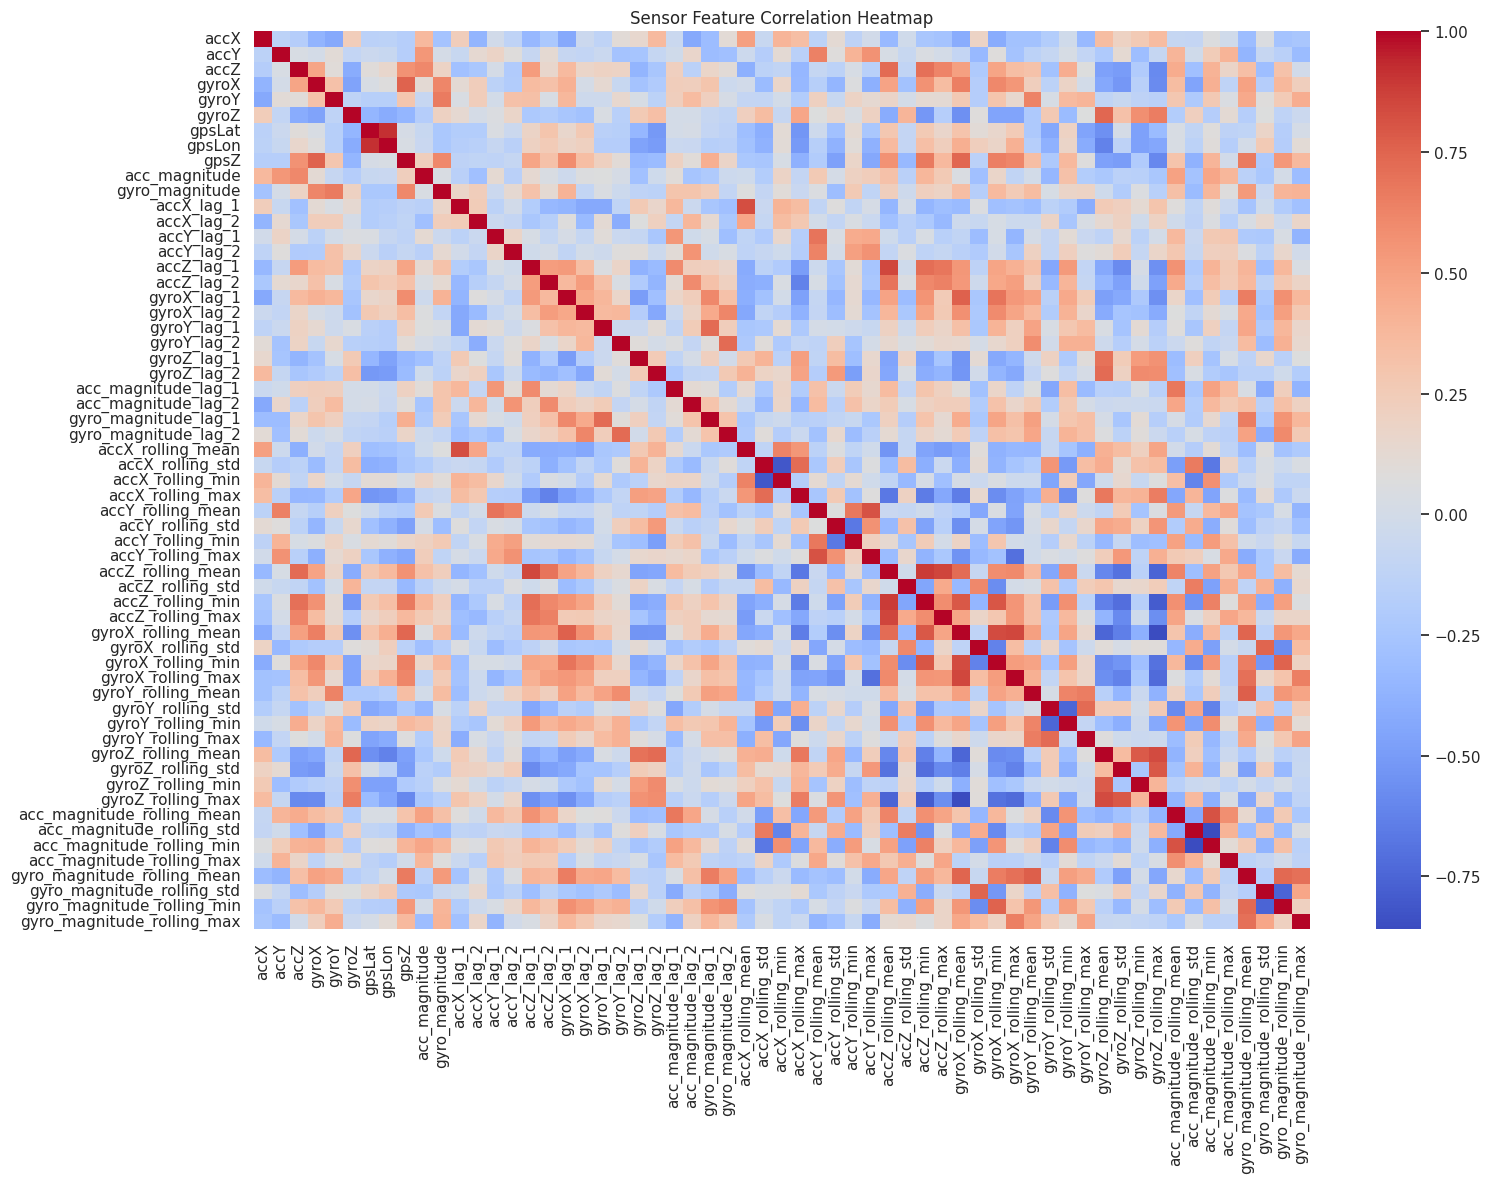

In [25]:
# Select only numeric sensor columns
sensor_cols = df.select_dtypes(include=[np.number]).columns

# Correlation matrix
corr = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Sensor Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


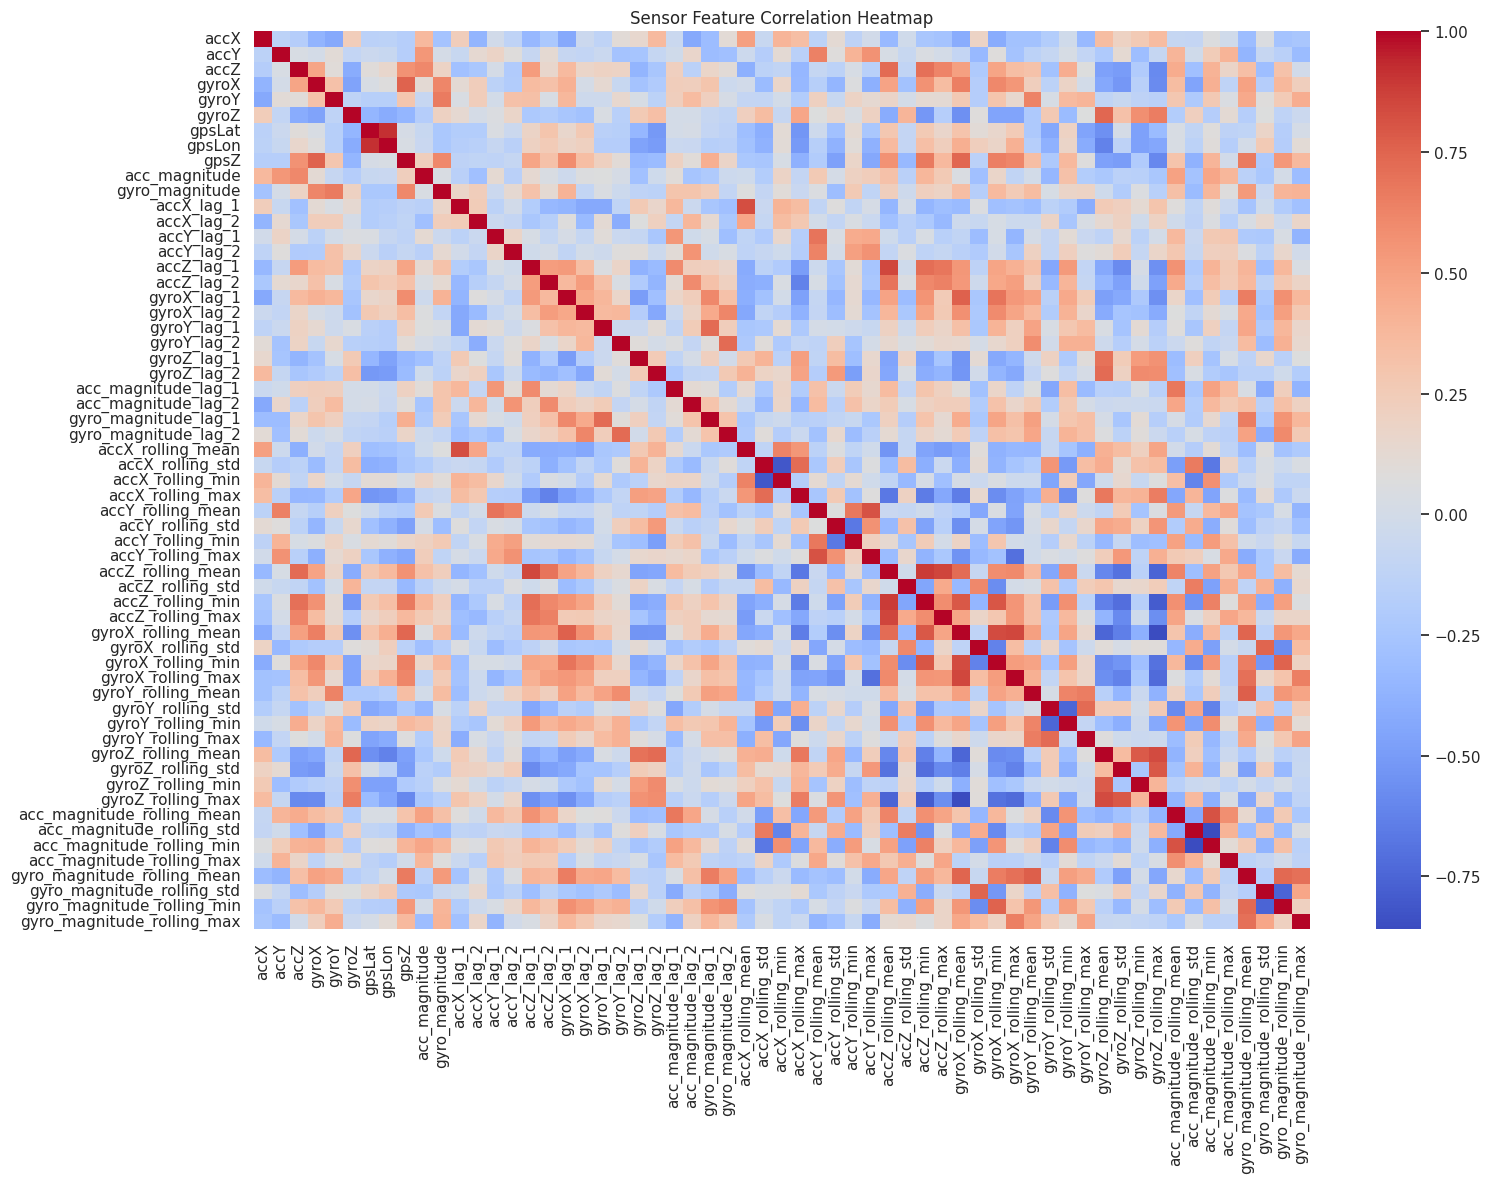

In [26]:
# Select only numeric sensor columns
sensor_cols = df.select_dtypes(include=[np.number]).columns

# Correlation matrix
corr = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Sensor Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


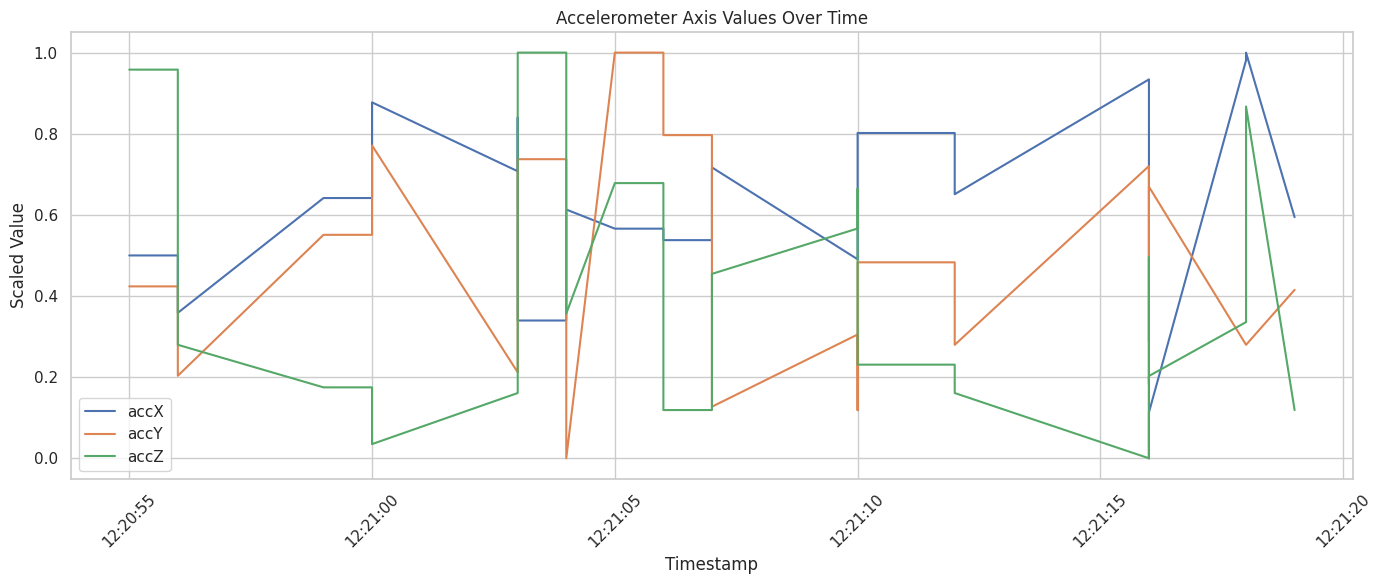

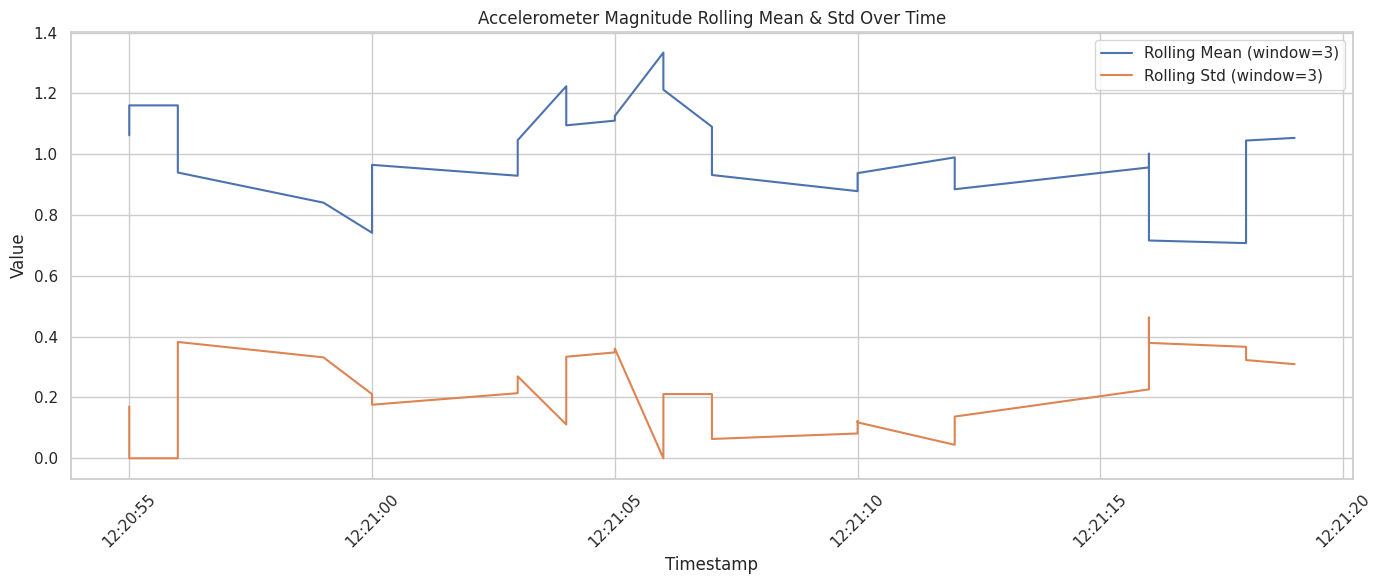

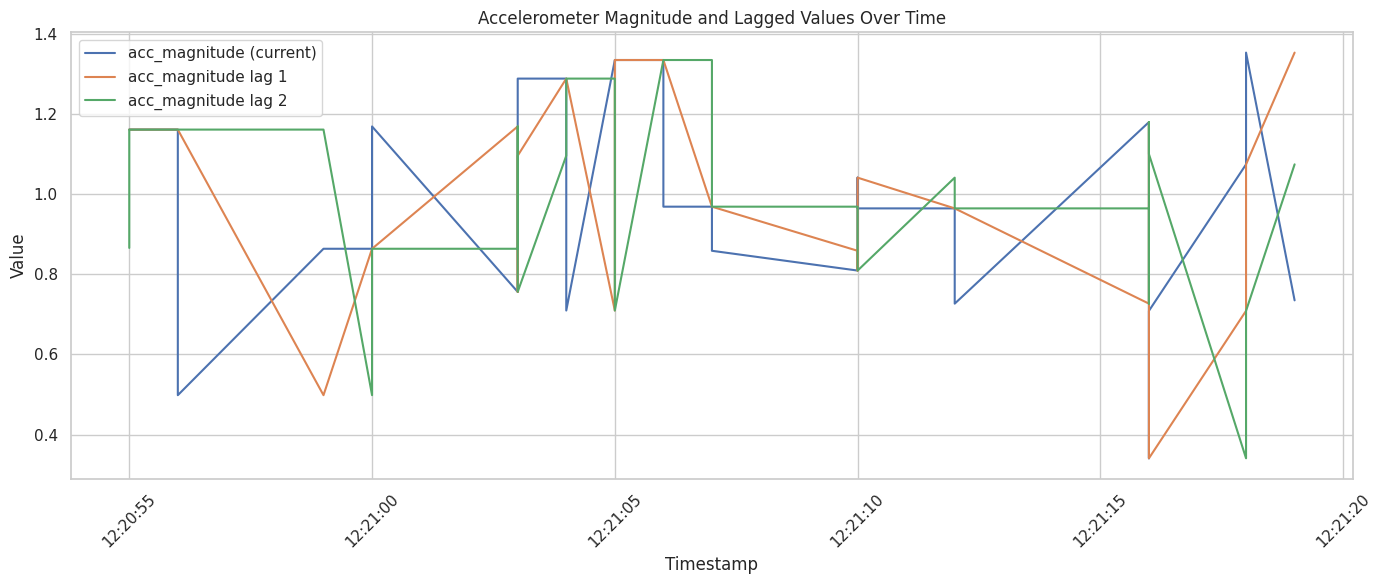

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the featured dataset
df = pd.read_csv('sensor_data1_featured.csv', parse_dates=['timestamp'])

# Set plot style
sns.set(style='whitegrid')

# 1. Plot raw sensor values over time (acceleration axes)
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['accX'], label='accX')
plt.plot(df['timestamp'], df['accY'], label='accY')
plt.plot(df['timestamp'], df['accZ'], label='accZ')
plt.title('Accelerometer Axis Values Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Scaled Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Plot rolling mean and std for acc_magnitude
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['acc_magnitude_roll_mean'], label='Rolling Mean (window=3)')
plt.plot(df['timestamp'], df['acc_magnitude_roll_std'], label='Rolling Std (window=3)')
plt.title('Accelerometer Magnitude Rolling Mean & Std Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Plot original acc_magnitude vs lagged values
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['acc_magnitude'], label='acc_magnitude (current)')
plt.plot(df['timestamp'], df['acc_magnitude_lag_1'], label='acc_magnitude lag 1')
plt.plot(df['timestamp'], df['acc_magnitude_lag_2'], label='acc_magnitude lag 2')
plt.title('Accelerometer Magnitude and Lagged Values Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv('sensor_data1_featured.csv', parse_dates=['timestamp'])

# Plot accelerometer magnitude and rolling mean interactively
fig = px.line(df, x='timestamp',
              y=['acc_magnitude', 'acc_magnitude_roll_mean', 'acc_magnitude_roll_std'],
              labels={'value':'Acceleration Magnitude', 'timestamp':'Time'},
              title='Interactive Accelerometer Magnitude and Rolling Stats Over Time')

fig.update_layout(legend_title_text='Features')
fig.show()


In [12]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('sensor_data1_preprocessed.csv', parse_dates=['timestamp'])

# Feature engineering
df['acc_magnitude'] = np.sqrt(df['accX']**2 + df['accY']**2 + df['accZ']**2)
df['gyro_magnitude'] = np.sqrt(df['gyroX']**2 + df['gyroY']**2 + df['gyroZ']**2)

lag_features = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'acc_magnitude', 'gyro_magnitude']
for feature in lag_features:
    df[f'{feature}_lag_1'] = df[feature].shift(1)
    df[f'{feature}_lag_2'] = df[feature].shift(2)

window_size = 3
for feature in lag_features:
    df[f'{feature}_rolling_mean'] = df[feature].rolling(window=window_size).mean()
    df[f'{feature}_rolling_std'] = df[feature].rolling(window=window_size).std()
    df[f'{feature}_rolling_min'] = df[feature].rolling(window=window_size).min()
    df[f'{feature}_rolling_max'] = df[feature].rolling(window=window_size).max()

# Replace deprecated fillna(method='ffill') with ffill() and bfill()
df = df.ffill().bfill()

# Save to CSV locally (adjust the path as needed)
df.to_csv('sensor_data1_featured.csv', index=False)

print("Feature engineering done. Saved to 'sensor_data1_featured.csv'")


Feature engineering done. Saved to 'sensor_data1_featured.csv'


In [13]:
import pandas as pd
import plotly.express as px

# Load the featured data
df = pd.read_csv('sensor_data1_featured.csv', parse_dates=['timestamp'])

# Plot acc_magnitude and its rolling mean over time interactively
fig = px.line(
    df,
    x='timestamp',
    y=['acc_magnitude', 'acc_magnitude_rolling_mean'],
    title='Accelerometer Magnitude and Rolling Mean Over Time',
    labels={'value': 'Magnitude', 'timestamp': 'Time'},
)

fig.update_layout(
    hovermode='x unified',
    legend_title_text='Features',
    xaxis=dict(rangeslider=dict(visible=True)),  # add a range slider on x-axis
    template='plotly_dark'  # nicer dark theme, can be changed or removed
)

fig.show()



In [14]:
import pandas as pd
import plotly.express as px

# Load your data
df = pd.read_csv('sensor_data1_featured.csv', parse_dates=['timestamp'])

# 3D scatter plot of accX, accY, accZ
fig = px.scatter_3d(
    df,
    x='accX',
    y='accY',
    z='accZ',
    color='timestamp',  # color points by time to see progression
    title='3D Accelerometer Data',
    labels={'accX': 'Accel X', 'accY': 'Accel Y', 'accZ': 'Accel Z'},
    opacity=0.7,
)

fig.show()


In [15]:
fig = px.scatter_3d(
    df,
    x='accX',
    y='accY',
    z='accZ',
    animation_frame=df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S'),
    title='Animated 3D Accelerometer Data Over Time',
    opacity=0.7,
)

fig.show()


In [16]:
# For gyro 3D data
df_gyro_3d = df[['timestamp', 'gyroX', 'gyroY', 'gyroZ']]
df_gyro_3d.to_csv('sensor_gyro_3d_data.csv', index=False)

# For GPS 3D data
df_gps_3d = df[['timestamp', 'gpsLat', 'gpsLon', 'gpsZ']]
df_gps_3d.to_csv('sensor_gps_3d_data.csv', index=False)


In [17]:
import plotly.express as px

# Make sure your GPS columns exist and are numeric
# Plot GPS latitude and longitude as a scatter line plot showing movement path

fig = px.line_mapbox(
    df,
    lat="gpsLat",
    lon="gpsLon",
    hover_name="timestamp",
    title="Movement Route Over Time",
    zoom=12,
    height=600
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()


In [18]:
import numpy as np
import plotly.graph_objects as go

# Calculate acceleration magnitude if not already present
df['acc_magnitude'] = np.sqrt(df['accX']**2 + df['accY']**2 + df['accZ']**2)

# Create a time index or use timestamp as categories
df['time_index'] = range(len(df))  # simple sequential index for heatmap

fig = go.Figure(data=go.Heatmap(
    z=[df['acc_magnitude']],
    x=df['timestamp'],   # x axis = time
    y=['Acceleration Magnitude'],  # single row label
    colorscale='Viridis',
    colorbar=dict(title='Magnitude')
))

fig.update_layout(
    title='Accelerometer Magnitude Heatmap Over Time',
    yaxis=dict(showticklabels=True)
)

fig.show()


In [33]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from dash import Dash, dcc, html, Input, Output

# Load your processed CSV file
df = pd.read_csv("sensor_data1_featured.csv", parse_dates=["timestamp"])

# Create magnitude column if not already present
if 'acc_magnitude' not in df:
    df['acc_magnitude'] = (df['accX']**2 + df['accY']**2 + df['accZ']**2)**0.5

app = Dash(__name__)

app.layout = html.Div([
    html.H1("Sensor Dashboard with GPS and 3D Viewer"),
    dcc.Tabs([
        dcc.Tab(label='GPS Map', children=[
            dcc.Graph(id='gps-map'),
        ]),
        dcc.Tab(label='3D Accelerometer Viewer', children=[
            dcc.Graph(id='3d-acc'),
        ]),
        dcc.Tab(label='Time Series (Acc Magnitude)', children=[
            dcc.Graph(id='acc-mag-plot'),
        ]),
    ])
])

@app.callback(
    Output('gps-map', 'figure'),
    Input('gps-map', 'id')
)
def update_gps_map(_):
    fig = px.scatter_mapbox(
        df,
        lat="gpsLat", lon="gpsLon",
        color="acc_magnitude",
        size="acc_magnitude",
        hover_name="timestamp",
        zoom=15,
        height=600
    )
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return fig

@app.callback(
    Output('3d-acc', 'figure'),
    Input('3d-acc', 'id')
)
def update_3d_plot(_):
    fig = go.Figure(data=[go.Scatter3d(
        x=df['accX'],
        y=df['accY'],
        z=df['accZ'],
        mode='markers',
        marker=dict(
            size=4,
            color=df['acc_magnitude'],
            colorscale='Viridis',
            opacity=0.8
        )
    )])
    fig.update_layout(scene=dict(
        xaxis_title='Acc X',
        yaxis_title='Acc Y',
        zaxis_title='Acc Z'
    ))
    return fig

@app.callback(
    Output('acc-mag-plot', 'figure'),
    Input('acc-mag-plot', 'id')
)
def update_acc_mag_plot(_):
    fig = px.line(df, x='timestamp', y='acc_magnitude', title='Accelerometer Magnitude Over Time')
    return fig

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>